In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

#### Creating the Baseline LSTM prediction model

In [3]:
#getting the data with Date as index
df = pd.read_csv('../Data/GOOG.csv').set_index('Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2497 entries, 2013-02-01 to 2022-12-30
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        2497 non-null   float64
 1   High        2497 non-null   float64
 2   Low         2497 non-null   float64
 3   Adj Close   2497 non-null   float64
 4   MSFT Close  2497 non-null   float64
 5   AMZN Close  2497 non-null   float64
 6   META Close  2497 non-null   float64
 7   AAPL Close  2497 non-null   float64
 8   7ma         2497 non-null   float64
 9   14ma        2497 non-null   float64
 10  21ma        2497 non-null   float64
 11  7atr        2497 non-null   float64
 12  14atr       2497 non-null   float64
 13  21atr       2497 non-null   float64
 14  7upper      2497 non-null   float64
 15  7lower      2497 non-null   float64
 16  14upper     2497 non-null   float64
 17  14lower     2497 non-null   float64
 18  21upper     2497 non-null   float64
 19  21lower     2497 

In [4]:
#separating the features and target variable
features = df.drop('Close', axis=1).values
target = df['Close'].values

#scaling them separately
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(features)
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

#recombing for sequence creation
scaled_data = np.hstack((scaled_features, scaled_target))

In [7]:
#function for creating sequences
def create_sequences(data, input_size):
    X, y = [], []
    for i in range(len(data) - input_size):
        X.append(data[i:i + input_size, :-1])  # All columns except Close (the last one)
        y.append(data[i + input_size, -1])  # Close only
    return np.array(X), np.array(y)

#creating sequences
input_size = 30  # using 30 day sequences
X, y = create_sequences(scaled_data, input_size)

In [8]:
# train test split
train_size = int(len(X) * 0.8)  #first 80% for train, rest for test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#check dimensions
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (1973, 30, 20), y_train shape: (1973,), X_test shape: (494, 30, 20), y_test shape: (494,)


In [9]:
#function to create the model
def create_model(units, dropout_rate, optimizer, loss):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [10]:
#GridSearchCV to find best params for model
model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'units': [50, 75, 100],
    'dropout_rate': [0.1, 0.2, 0.3],
    'optimizer' : ['adam', 'sgd', 'rmsprop'],
    'loss' : ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(X_train, y_train)

print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\catri\AppData\Local\Temp/ipykernel_34104/3030747616.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best score: -0.000367 using {'dropout_rate': 0.2, 'loss': 'mean_squared_error', 'optimizer': 'adam', 'units': 100}


In [11]:
#creating the model with choen parameters
model = create_model(units=100, dropout_rate=0.2, optimizer='adam', loss='mean_squared_error')

print(model.summary()) #printing model summary
model.save('baseline_lstm_model.h5') #saving the model

Model: "sequential_244"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_488 (LSTM)             (None, 30, 100)           48400     
                                                                 
 dropout_488 (Dropout)       (None, 30, 100)           0         
                                                                 
 lstm_489 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_489 (Dropout)       (None, 100)               0         
                                                                 
 dense_244 (Dense)           (None, 1)                 101       
                                                                 
Total params: 128,901
Trainable params: 128,901
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
#fitting the model 
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
62/62 - 10s - loss: 0.0026 - 10s/epoch - 154ms/step
Epoch 2/100
62/62 - 3s - loss: 6.4599e-04 - 3s/epoch - 42ms/step
Epoch 3/100
62/62 - 3s - loss: 5.3910e-04 - 3s/epoch - 43ms/step
Epoch 4/100
62/62 - 3s - loss: 4.7647e-04 - 3s/epoch - 42ms/step
Epoch 5/100
62/62 - 3s - loss: 4.5261e-04 - 3s/epoch - 42ms/step
Epoch 6/100
62/62 - 3s - loss: 5.3896e-04 - 3s/epoch - 42ms/step
Epoch 7/100
62/62 - 3s - loss: 3.9005e-04 - 3s/epoch - 42ms/step
Epoch 8/100
62/62 - 3s - loss: 3.8196e-04 - 3s/epoch - 42ms/step
Epoch 9/100
62/62 - 3s - loss: 4.0947e-04 - 3s/epoch - 41ms/step
Epoch 10/100
62/62 - 3s - loss: 3.7584e-04 - 3s/epoch - 42ms/step
Epoch 11/100
62/62 - 3s - loss: 4.4714e-04 - 3s/epoch - 42ms/step
Epoch 12/100
62/62 - 3s - loss: 3.3536e-04 - 3s/epoch - 42ms/step
Epoch 13/100
62/62 - 3s - loss: 3.8098e-04 - 3s/epoch - 41ms/step
Epoch 14/100
62/62 - 3s - loss: 3.4842e-04 - 3s/epoch - 41ms/step
Epoch 15/100
62/62 - 3s - loss: 3.2750e-04 - 3s/epoch - 41ms/step
Epoch 16/100
62/62 -

In [13]:
#making predictions
y_pred = model.predict(X_test)

#scaling back
y_pred_rescaled = target_scaler.inverse_transform(y_pred)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

#calculating the RMSE 
baseline_rmse = sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
baseline_rmse = round(baseline_rmse, 4) #rounding it to 4 decimal places
print("RMSE for baseline model on Google data: " + str(baseline_rmse))

16/16 [==============================] - 1s 15ms/step
RMSE for baseline model on Google data: 7.7178


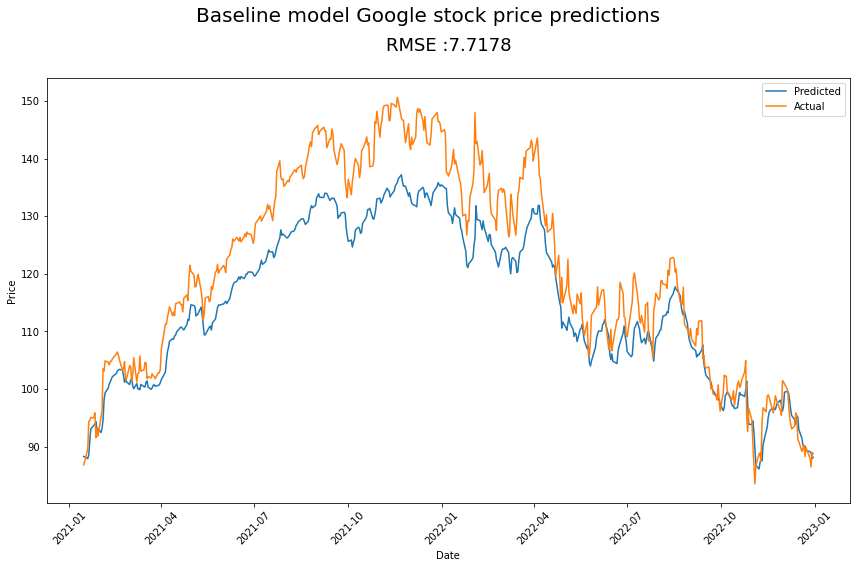

In [14]:
#Plotting the predictions
 
#making Date datetime
df.index = pd.to_datetime(df.index)
#get corresponding dates to y_test_rescaled
test_dates = df.index[-len(y_test_rescaled):]

#creating the plot
plt.figure(figsize=(12,8))
plt.plot(test_dates, y_pred_rescaled, label='Predicted')
plt.plot(test_dates, y_test_rescaled, label='Actual')
plt.suptitle("Baseline model Google stock price predictions", size=20)
plt.title(f"RMSE :{baseline_rmse}", size=18, y=1.05)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()